In [2]:
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-03-23 08:20:50 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-23 08:20:50 INFO: Use device: cpu
2021-03-23 08:20:50 INFO: Loading: tokenize
2021-03-23 08:20:50 INFO: Loading: pos
2021-03-23 08:20:52 INFO: Loading: lemma
2021-03-23 08:20:52 INFO: Loading: depparse
2021-03-23 08:20:55 INFO: Done loading processors!
2021-03-23 08:20:55 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-23 08:20:55 INFO: Use device: cpu
2021-03-23 08:20:55 INFO: Loading: tokenize
2021-03-23 08:20:55 INFO: Done loading processors!


In [3]:
det_type_words = {
    "det:univ": ["all", "every", "each", "any", "all-of-the"],
    "det:exist": ["a", "an", "some", "double", "triple", "some-of-the", "al-least", "more-than"],
    "det:limit": ["such", "both", "the", "this", "that",
                  "those", "these", "my", "his", "her",
                  "its", "either", "both", "another"],
    "det:negation": ["no", "neither", "never", "none", "none-of-the", "less-than", "at-most", "few"]
}

In [4]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [5]:
from pattern.en import pluralize, singularize
from copy import copy

class ContradictionGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.tree_log = []
        self.sent_log = []
        
    def deptree_negation_generate(self, tree, annotated, original):
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.original = original  
        self.annotated = deepcopy(annotated)
        pop_list = list(annotated.popkeys())
        unziped = list(zip(*pop_list))

        self.sentence = list(unziped[0])
        self.word_ids = unziped[3]
        self.pos_tags = unziped[1]
        self.polarities = unziped[2]
        self.beVerb = False
        self.nots = 1
        self.nsubjs = 0
        self.notDet = 1
        self.expl = False
        
        self.generate_not(self.deptree)
        self.negate_det(self.deptree)
        

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.negates = backup.negates
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def negate_det(self, tree):
        
        if tree.val == "nsubj":
            self.nsubjs += 1
            orig = self.nsubjs
            self.negate_det(tree.left)
            self.nsubjs = orig
            self.negate_det(tree.right)
            return
        
        if tree.val == "det" and self.nsubjs == 1:
            target = self.down_right(tree.left)
            sentence = deepcopy(self.sentence)
            if(target.val.lower() in det_type_words["det:exist"]):
                sentence[target.id-1] = "no"
                self.sent_log.append((' ').join(sentence))
            elif(target.val.lower() in det_type_words["det:negation"]):
                sentence[target.id-1] = "some"
                self.sent_log.append((' ').join(sentence))
            elif(target.val.lower() in  det_type_words["det:univ"] and self.notDet == 1):
                sentence.insert(target.id-1, "not")
                self.notDet -= 1
                self.sent_log.append((' ').join(sentence))
    
  #  "det:limit"
     
        if tree.is_tree:
            self.negate_det(tree.left)
            self.negate_det(tree.right) 
    
    def down_right(self, tree):
        if(tree.right != None):
            return self.down_right(tree.right)
        return tree
    
    def add_not(self, tree, modifier):
        if(self.nots < 1):
            return
        if self.beVerb:
            index = self.down_right(tree.left).id
        elif self.expl:
            index = self.down_right(tree).id
        else:
            index = self.down_right(tree).id-1
        sentence = deepcopy(self.sentence)
        sentence.insert(index, modifier)
        if("not" in modifier):
            self.sent_log.append(' '.join(sentence))
            self.nots -= 1
            


    def generate_not(self, tree):
        '''if tree.pos is not None:
            if "VB" in tree.pos:
                self.add_modifier_lexical(tree, "not", tree.val, tree.id)
                self.add_modifier_lexical(tree, "not", tree.val, tree.id, 1)'''
        if tree.val == "expl":
            self.expl = True
            
        if tree.val in ["aux", "cop"]:
            self.beVerb = True
            self.add_not(tree, "not")
        elif tree.val in ["obj", "obl", "xcomp"] and not self.beVerb:
            self.add_not(tree, "do not")
        elif self.expl and tree.val == "nsubj":
            self.add_not(tree, "not")
            self.expl = False
        
        if tree.is_tree:
            self.generate_not(tree.left)
            self.generate_not(tree.right) 

    def save_tree(self, isTree):
        if isTree:
            leaves = self.deptree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            self.tree_log.append(self.deptree.copy())
            #polarized = pipeline.postprocess(self.deptree, {})
            #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
            #jupyter_draw_nltk_tree(btreeViz) 
            #leaves = copy(self.deptree).sorted_leaves().popkeys()
            #sentence = ' '.join([x[0] for x in leaves]) 
        else:
            annotated_cp = deepcopy(self.annotated)
            self.sent_log.append(
                ' '.join([word[0] for word in list(annotated_cp.popkeys())]))

    def buildTree(self, config):
        left = BinaryDependencyTree(
            config['mod'], "N", "N", 1024, 
            wid=config['lid'], pos="JJ")
        right = BinaryDependencyTree(
            config['head'], "N", "N", 1024,
            wid=config['rid'], pos="NN")
        tree = BinaryDependencyTree(config['rel'], left, right, 1025)
        left.mark = config['mark']
        right.mark = config['mark']
        tree.mark = config['mark']
        return tree

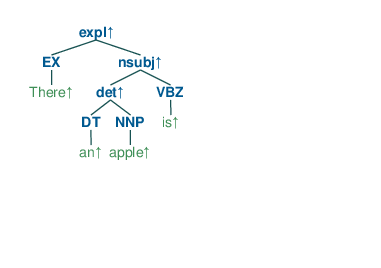

['There is not an apple', 'There is no apple']


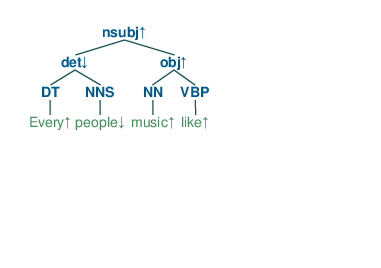

['Every people do not like music', 'not Every people like music']


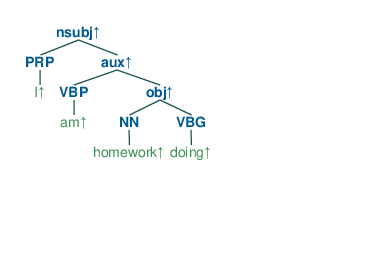

['I am not doing homework']


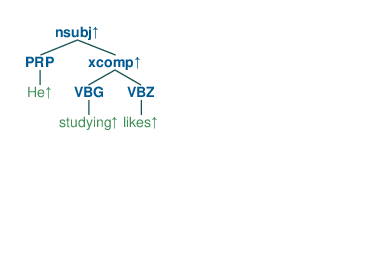

['He do not likes studying']


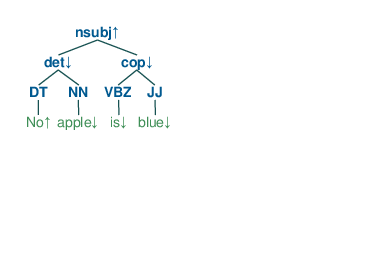

['No apple is not blue', 'some apple is blue']


In [7]:
sentences = ["There is an apple","Every people like music", "I am doing homework", "He likes studying", "No apple is blue"]#, "There is a sweet apple","There is not a sweet apple"]    

pipeline = PolarizationPipeline(verbose = 0)
pg = ContradictionGenerator()

for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree1 = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree1.replace('[', '(').replace(']', ')'))
    pg.deptree_negation_generate(annotation["polarized_tree"],annotation["annotated"],annotation["original"])
    #tree_visuals.append(svgling.draw_tree(tree1))
    jupyter_draw_nltk_tree(btree)
    print(pg.sent_log)

In [ ]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

upward = ["Some students sing to celebrate their graduation",
          "An Irishman won the nobel prize for literature.",
          "A big poison spider was spanning a web", 
          "A Californian special policeman pulled a car over and spoke to the driver",
          "A woman is dancing in a cage", 
          "A woman is dancing beautifully in a cage", 
          "People are riding and paddling a raft", 
          "Some delegates finished the survey on time"]

sick_upward = ["A brown dog is attacking another animal in front of the tall man in pants",
               "A skilled person is riding a bicycle on one wheel",
               "Two children are lying in the snow and are drawing angels"]

downward = ["No spider was spanning a web",
            "No student finished homework",
            "I've never flown in an airplane"]

hypothesis = ["No poison spider was spanning a web", 
              "No student at school finished homework compeletly",
              "I've never flown in an airplane because i'm afraid."] 

In [ ]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])

In [ ]:
from tqdm import tqdm

annotations = []
with open("./generation_log_donward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(len(MED_downward))):
        h_parsed, _ = dependency_parse(MED_downward_hypo[i], parser="stanza")
        h_tree, _ = pipeline.run_binarization(h_parsed, MED_downward_hypo[i], {})
        nn_phrases = dict()
        vb_phrases = dict()
        collect_modifiers(h_tree, nn_phrases, mod_type="NN")
        collect_modifiers(h_tree, vb_phrases, mod_type="VB")
        annotation = pipeline.single_polarization(MED_downward[i])
        annotation['polarized_tree'].negates = h_tree.negates
        
        #print("\n====================================")
        generate_log.write("\n====================================")
        
        phrasalGenerator.kb = merge(nn_phrases, vb_phrases)
        #print(phrasalGenerator.kb)
       
        #print("\nInit Premise: " + annotation['original'])
        generate_log.write("\nInit Premise: " + annotation['original'])
        generate_log.write("\nHypothesis: " + MED_downward_hypo[i])
        
        #polarized = pipeline.postprocess(annotation['polarized_tree'], {})
        #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
        #jupyter_draw_nltk_tree(btreeViz) 
        
        print(annotation['polarized_tree'].negates)
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            annotation['original'])

        for gen_tree in phrasalGenerator.tree_log:
            leaves = gen_tree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            #print("\nNext Premise: " + sentence)
            generate_log.write("\nNext Premise: " + sentence)
        
        for gen_sent in set(phrasalGenerator.sent_log):
            #print("\nNext Premise: " + gen_sent)
            generate_log.write("\nNext Premise: " + gen_sent)


In [ ]:
up = ["few female committee members are from southern Europe."]
up_h = ["Not few female committee members are from southern Europe."]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    h_parsed, _ = dependency_parse(up_h[i], parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, up_h[i], {})
    nn_phrases = {} 
    vb_phrases = {} 
    negates = collect_modifiers(h_tree, nn_phrases, mod_type="NN") + collect_modifiers(h_tree, vb_phrases, mod_type="VB")
    annotation = pipeline.single_polarization(up[i])
    annotation['polarized_tree'].negates = negates
    
    print("\n====================================")
    phrasalGenerator.kb = merge(nn_phrases, vb_phrases)
    print(phrasalGenerator.kb)
    
    print("\nInit Premise: " + annotation['original'])
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btree = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree) 
    
    
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], 
        annotation['original'])

    for gen_tree in phrasalGenerator.tree_log:
        leaves = gen_tree.sorted_leaves().popkeys()
        sentence = ' '.join([x[0] for x in leaves])
        print("\nNext Premise: " + sentence)
    
    for gen_sent in set(phrasalGenerator.sent_log):
        print("\nNext Premise: " + gen_sent)

In [ ]:
polarized = "[nsubj  (NOUN  researchers)  (ccomp  (mark  (SCONJ  that)  (nsubj  (acl  (advmod  (ADV  first)  (obl  (case  (ADP  in)  (PROPN  Britain))  (VERB  identified)))  (acl:relcl  (nsubj:pass  (PRON  which)  (aux:pass  (AUX  is)  (xcomp  (mark  (PART  to)  (advmod  (ADV  more)  (cop  (AUX  be)  (ADJ  infectious))))  (VERB  believed))))  (det  (DET  the)  (NOUN  variant))))  (aux  (AUX  could)  (xcomp  (nmod  (case  (ADP  of)  (det  (DET  the)  (NOUN  virus)))  (nmod  (case  (ADP  in)  (det  (DET  this)  (NOUN  country)))  (det  (DET  the)  (amod  (ADJ  dominant)  (NOUN  form)))))  (obl  (case  (ADP  by)  (PROPN  March))  (VERB  become))))))  (aux  (AUX  have)  (obl  (case  (ADP  In)  (compound  (PROPN  United)  (PROPN  States)))  (VERB  warned))))]"

In [ ]:
btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
jupyter_draw_nltk_tree(btreeViz) 